In [16]:
import pandas as pd
import altair_ally as aly
import altair as alt
import matplotlib.pyplot as plt

In [6]:
aly.alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


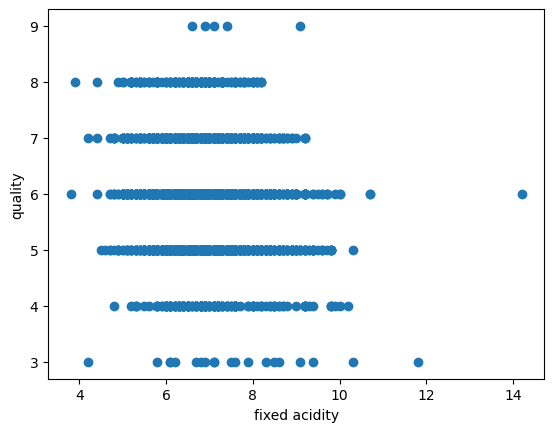

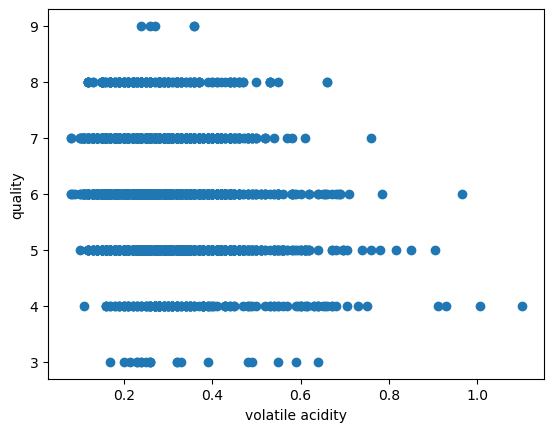

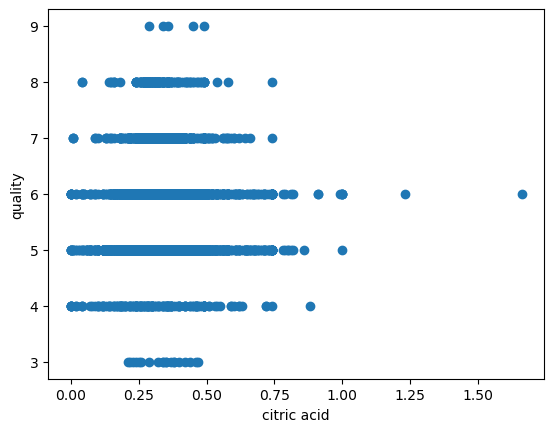

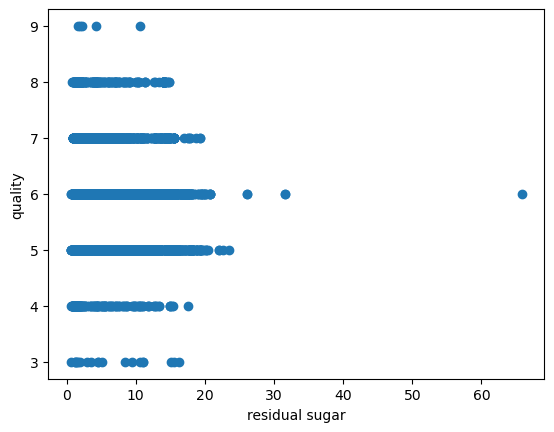

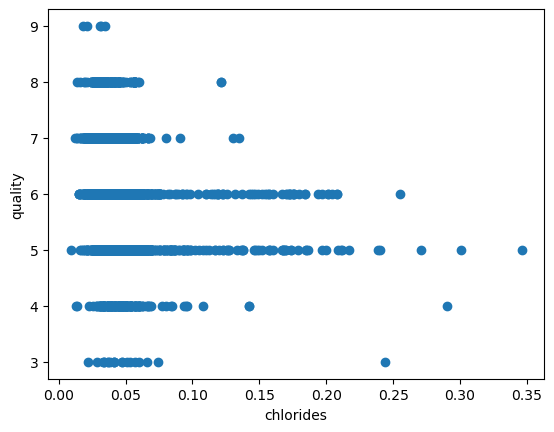

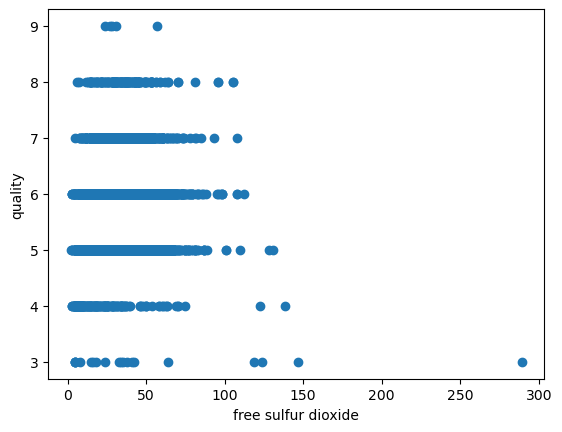

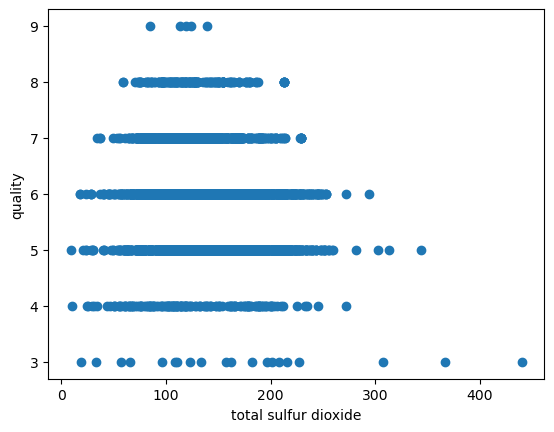

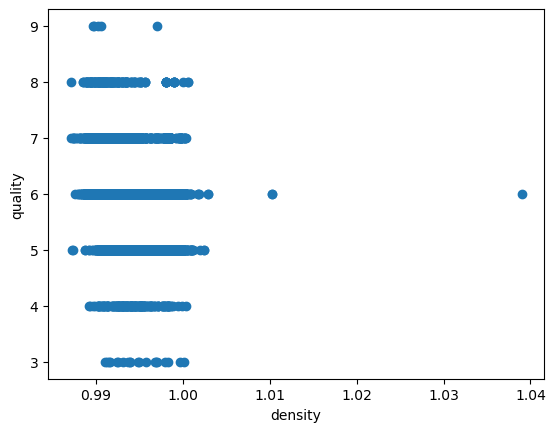

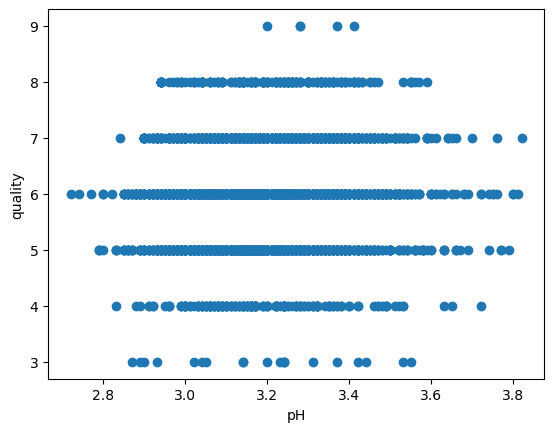

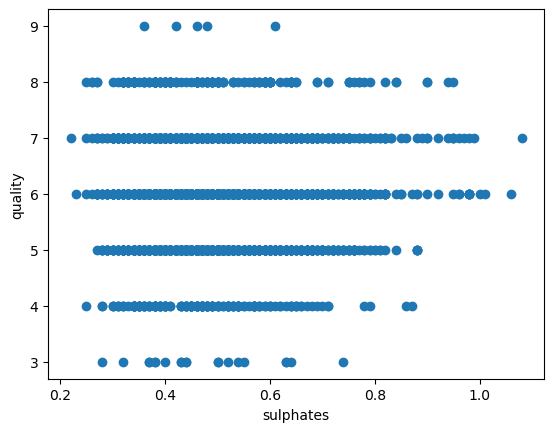

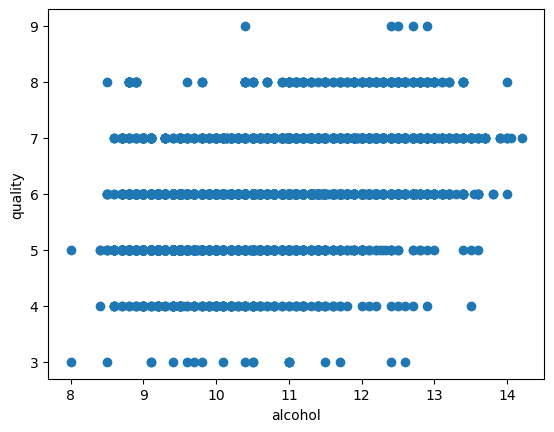

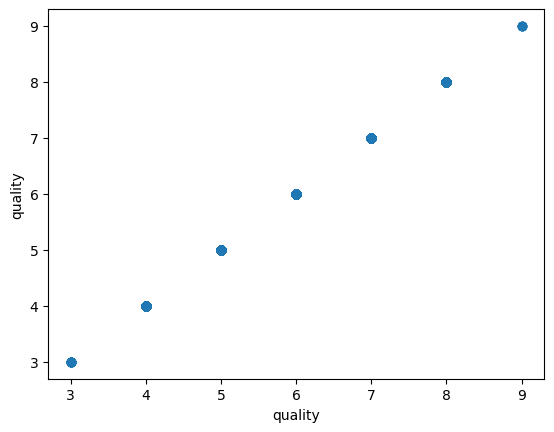

In [23]:
origin_df = pd.read_csv('data/winequality-white.csv', sep=';', encoding='utf-8')
print(origin_df['quality'].value_counts())

for i in origin_df.columns.tolist():
    feat = i
    plt.plot(origin_df[feat], origin_df['quality'], 'o')
    plt.xlabel(feat)
    plt.ylabel('quality')
    plt.show()


In [21]:
aly.corr(origin_df)

/Users/xiezhihao/miniforge3/envs/dsci-573/lib/python3.12/site-packages/altair/utils/data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
/Users/xiezhihao/miniforge3/envs/dsci-573/lib/python3.12/site-packages/altair/utils/data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_dataframe(obj) or isinstance(
/Users/xiezhihao/miniforge3/envs/dsci-573/lib/python3.12/site-packages/altair/utils/data.py:71: UserWarning: You passed a `<class 'narwhals.stable.v1.DataFrame'>` to `is_pandas_dataframe`.

Hint: Instead of e.g. `is_pandas_dataframe(df)`, did you mean `is_pandas_dataframe(df.to_native())`?
  return _is_pandas_datafra

alt.ConcatChart(...)

In [8]:
origin_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
